# Outlier Detection & Treatment — A Practical Guide

This notebook demonstrates:

- How to detect outliers using visual, statistical, and algorithmic methods  
- How context affects outlier interpretation  
- How to treat outliers using removal, capping, imputation, feature engineering, and robust models  

We use a simple synthetic dataset to keep concepts clear and intuitive.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
import scipy.stats as stats

np.random.seed(42)

# Create normal data
normal_data = np.random.normal(loc=50, scale=5, size=200)

# Add clear outliers
outliers = np.array([20, 100, 120])

# Combine
data = np.concatenate([normal_data, outliers])
df = pd.DataFrame({"value": data})

df.head()

,value
0,52.483571
1,49.308678
2,53.238443
3,57.615149
4,48.829233


In [18]:
# Compute IQR outliers BEFORE plotting anything
Q1 = df["value"].quantile(0.25)
Q3 = df["value"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["IQR_outlier"] = (df["value"] < lower) | (df["value"] > upper)

## 1. Visual Detection

Visual methods are the quickest way to spot unusual points:
- Boxplot → extreme values outside whiskers  
- Histogram → strange frequency patterns  

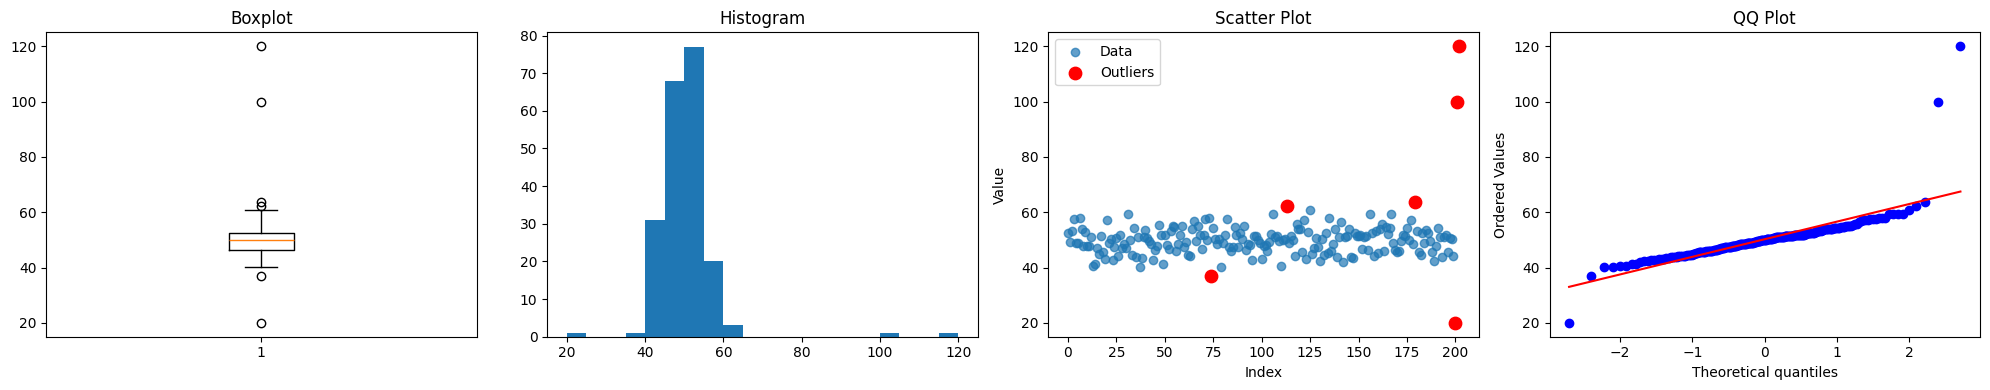

In [19]:
# Visual Detection: Boxplot, Histogram, Scatter Plot, QQ Plot
import scipy.stats as stats

plt.figure(figsize=(20,4))

# Boxplot
plt.subplot(1,4,1)
plt.boxplot(df["value"])
plt.title("Boxplot")

# Histogram
plt.subplot(1,4,2)
plt.hist(df["value"], bins=20)
plt.title("Histogram")

# Scatter Plot (highlighting IQR outliers)
plt.subplot(1,4,3)
plt.scatter(range(len(df)), df["value"], label="Data", alpha=0.7)
plt.scatter(df[df["IQR_outlier"]].index,
            df[df["IQR_outlier"]]["value"],
            color="red", s=80, label="Outliers")
plt.title("Scatter Plot")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# QQ Plot
plt.subplot(1,4,4)
stats.probplot(df["value"], dist="norm", plot=plt)
plt.title("QQ Plot")

plt.tight_layout()
plt.show()

## 2. Statistical Methods

We apply:
- IQR  
- Z-score  
- Standard deviation rule  

In [ ]:
# IQR Method

df["IQR_outlier"] = (df["value"] < lower) | (df["value"] > upper)
df["IQR_outlier"].value_counts()

IQR_outlier
False    197
True       6
Name: count, dtype: int64

In [21]:
# Z-Score Method

df["z_score"] = (df["value"] - df["value"].mean()) / df["value"].std()
df["Z_outlier"] = df["z_score"].abs() > 3
df["Z_outlier"].value_counts()

Z_outlier
False    200
True       3
Name: count, dtype: int64

In [23]:
# Standard Deviation Rule (3-sigma rule)
mean_val = df["value"].mean()
std_val = df["value"].std()

df["SD_outlier"] = (df["value"] < mean_val - 3 * std_val) | \
                   (df["value"] > mean_val + 3 * std_val)
df["SD_outlier"].value_counts()

SD_outlier
False    200
True       3
Name: count, dtype: int64

## 3. Algorithmic Methods

We apply:
- Isolation Forest  
- DBSCAN  

In [6]:
# Isolation Forest

iso = IsolationForest(contamination=0.02, random_state=42)
df["IF_outlier"] = iso.fit_predict(df[["value"]]) == -1
df["IF_outlier"].value_counts()

IF_outlier
False    198
True       5
Name: count, dtype: int64

In [7]:
#DBSCAN
db = DBSCAN(eps=3, min_samples=5)
df["DBSCAN_label"] = db.fit_predict(df[["value"]])
df["DBSCAN_outlier"] = df["DBSCAN_label"] == -1
df["DBSCAN_outlier"].value_counts()

DBSCAN_outlier
False    199
True       4
Name: count, dtype: int64

## 4. Outlier Treatment Strategies

We demonstrate:
- Removal  
- Capping (Winsorizing)  
- Imputation  
- Feature engineering  
- Robust models  

In [ ]:
#Removal
df_removed = df[~df["IQR_outlier"]]
df_removed.head()

,value,IQR_outlier,z_score,Z_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,0,False
1,49.308678,False,-0.118198,False,False,0,False
2,53.238443,False,0.379206,False,False,0,False
3,57.615149,False,0.933182,False,False,0,False
4,48.829233,False,-0.178883,False,False,0,False


In [9]:
#Capping (Winsorizing)
df_capped = df.copy()
df_capped["value"] = np.clip(df_capped["value"], lower, upper)
df_capped.head()

,value,IQR_outlier,z_score,Z_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,0,False
1,49.308678,False,-0.118198,False,False,0,False
2,53.238443,False,0.379206,False,False,0,False
3,57.615149,False,0.933182,False,False,0,False
4,48.829233,False,-0.178883,False,False,0,False


In [10]:
#Imputation
df_imputed = df.copy()
median_val = df["value"].median()
df_imputed.loc[df["IQR_outlier"], "value"] = median_val
df_imputed.head()

,value,IQR_outlier,z_score,Z_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier
0,52.483571,False,0.283659,False,False,0,False
1,49.308678,False,-0.118198,False,False,0,False
2,53.238443,False,0.379206,False,False,0,False
3,57.615149,False,0.933182,False,False,0,False
4,48.829233,False,-0.178883,False,False,0,False


In [11]:
#Add an Outlier Flag
df["outlier_flag"] = df["IQR_outlier"].astype(int)
df.head()

,value,IQR_outlier,z_score,Z_outlier,IF_outlier,DBSCAN_label,DBSCAN_outlier,outlier_flag
0,52.483571,False,0.283659,False,False,0,False,0
1,49.308678,False,-0.118198,False,False,0,False,0
2,53.238443,False,0.379206,False,False,0,False,0
3,57.615149,False,0.933182,False,False,0,False,0
4,48.829233,False,-0.178883,False,False,0,False,0
